In [326]:
import os
import pandas as pd
import optuna
import numpy as np
import openml
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import kaleido
import plotly
import scipy.stats as stats
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from optuna.samplers import TPESampler, CmaEsSampler
from xgboost import XGBClassifier
from plotly.io import show
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [327]:
optuna.logging.set_verbosity(logging.ERROR)

In [328]:
dataset_ids = [
    1590,   # Adult
    1510,   # Breast Cancer Wisconsin (Diagnostic)
    1461,   # Bank Marketing
    24,     # Mushroom
    40945   # Titanic
]

In [329]:
def fetch_and_prepare(openml_id):
    global y
    global X
    dataset = openml.datasets.get_dataset(openml_id)
    print(f">>> {dataset.name} (ID: {openml_id})")
    X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')
    for col in X.select_dtypes(include=['category', 'object']):
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    imputer = SimpleImputer(strategy='mean')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    scaler = MinMaxScaler()
    X_imputed = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)
    if y.dtype == 'category':
        y = LabelEncoder().fit_transform(y)
    zbior = X_imputed['Target'] = y
    return X_imputed

In [330]:
zbior = fetch_and_prepare(1590)

>>> adult (ID: 1590)


# Optymalizacja hiperparametrów - zbiór Adult

## Regresja logistyczna

In [331]:
np.random.seed(42)

X_25, X_discard, y_25, y_discard = train_test_split(
    zbior.iloc[:, :-1], zbior['Target'],
    train_size=0.25,        
    stratify=y,             
    random_state=42         
)
X_25['Target'] = y_25
zbior = X_25

In [332]:
X_train, X_test, y_train, y_test = train_test_split(zbior.iloc[:, :-1], zbior['Target'], test_size=0.30, random_state=42)

def objective(trial):

    solver = trial.suggest_categorical('solver',['lbfgs','newton-cg','newton-cholesky','sag','saga'])
    penalty,l1_ratio = None,None

    if solver == 'lbfgs' or solver == 'newton-cg' or solver == 'newton-cholesky' or solver == 'sag':
        penalty = trial.suggest_categorical('penalty', ['l2'])
    elif solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'elasticnet'])
        if penalty == 'elasticnet':
            l1_ratio = trial.suggest_float('l1_ratio', 1e-5, 1.0)
         
    C = trial.suggest_float('C', 1e-4, 1e4, log=True)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    wyniki = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_fold = X_train_fold.reset_index(drop=True)
        X_test_fold = X_test_fold.reset_index(drop=True)
        y_train_fold = y_train_fold.reset_index(drop=True)
        y_test_fold = y_test_fold.reset_index(drop=True)

        X_train_fold = list(zip(*[X_train_fold[col] for col in X_train_fold]))
        X_test_fold = list(zip(*[X_test_fold[col] for col in X_test_fold]))

        regresja_logistyczna = LogisticRegression(penalty = penalty, C=C, solver=solver, l1_ratio=l1_ratio, max_iter=10000, random_state=42,
                                                  ).fit(X_train_fold, y_train_fold)
        regresja_logistyczna.predict(X_test_fold)

        wynik = regresja_logistyczna.score(X_test_fold, y_test_fold)
        wyniki.append(wynik)

    rezultat = np.mean(wyniki)
    return rezultat

In [333]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
wynik = study.optimize(objective, n_trials=1000)

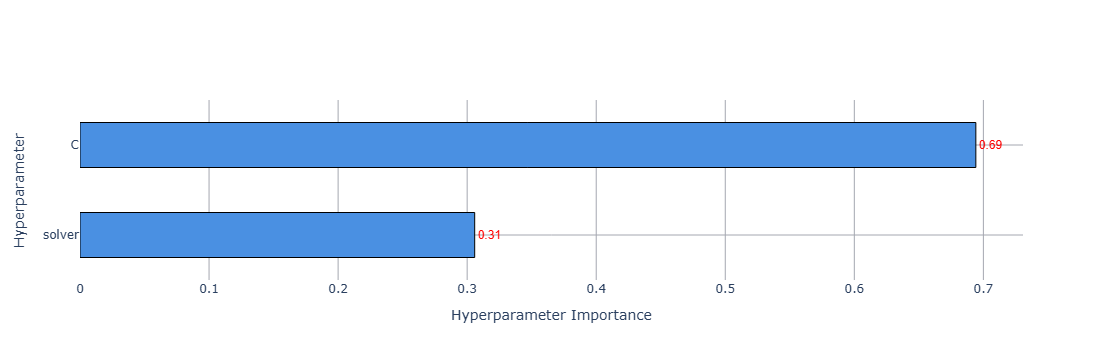

In [8]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_traces(marker_color='#4A90E2')
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    xaxis=dict(
        gridcolor='#a4a7b0', 
        gridwidth=1
    ),
    yaxis=dict(
        gridcolor = '#a4a7b0',
        gridwidth=1
    ))

fig.update_traces(
    marker=dict(
        line=dict(
            color='black',
            width=1)),
    textfont=dict(
        color='red', family='Arial Bold, sans-serif'),
    width=0.5)

fig.update_layout(title=None)

show(fig)

fig.write_image("newplot1.png",width=800, height=300,scale = 5)
plt.close()

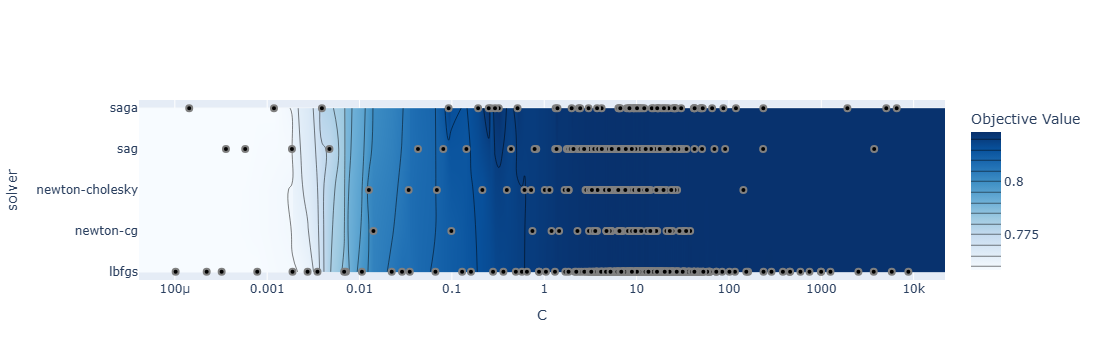

In [9]:
fig = optuna.visualization.plot_contour(study, params=["solver", "C"])
fig.update_layout(title_text="Wykres wpływu hiperparametrów na proces optymalizacji ")
fig.update_layout(title=None)
fig.write_image("newplot2.png",width=800, height=300,scale = 5)
show(fig)

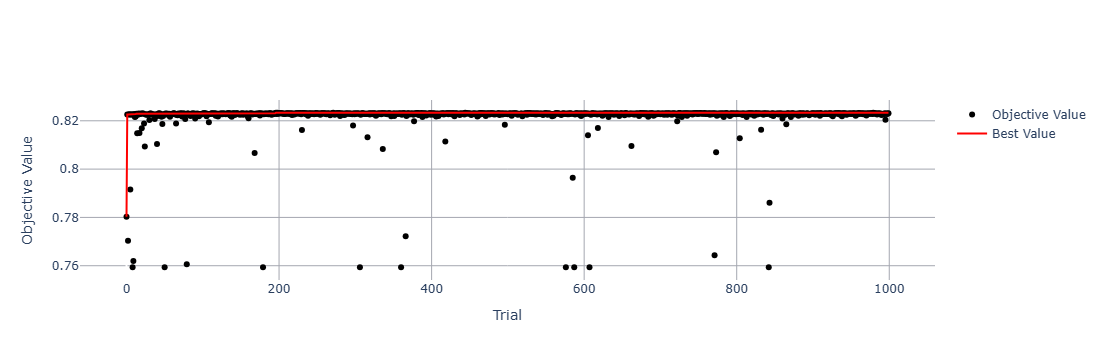

In [122]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(title_text="Proces optymalizacji ")
fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
    xaxis=dict(
        gridcolor='#a4a7b0', 
        gridwidth=1
    ),
    yaxis=dict(
        gridcolor = '#a4a7b0',
        gridwidth=1
    ))

fig.data[1].line.color = 'red'
fig.data[1].line.width = 2

fig.data[0].line.color = 'black'


fig.update_layout(title=None)
fig.write_image("newplot3.png",width=800, height=300,scale = 5)

show(fig)

In [334]:
##Default
kf = KFold(n_splits=5, shuffle=True, random_state=42)
wyniki = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    X_train_fold = X_train_fold.reset_index(drop=True)
    X_test_fold = X_test_fold.reset_index(drop=True)
    y_train_fold = y_train_fold.reset_index(drop=True)
    y_test_fold = y_test_fold.reset_index(drop=True)

    X_train_fold = list(zip(*[X_train_fold[col] for col in X_train_fold]))
    X_test_fold = list(zip(*[X_test_fold[col] for col in X_test_fold]))

    regresja_logistyczna = LogisticRegression(penalty = 'elasticnet', C=0.001, solver='saga', l1_ratio=1, max_iter=10000, random_state=42,
                                                  ).fit(X_train_fold, y_train_fold)
    regresja_logistyczna.predict(X_test_fold)

    wynik = regresja_logistyczna.score(X_test_fold, y_test_fold)
    wyniki.append(wynik)

rezultat = float(np.mean(wyniki))
print(rezultat)

0.7540668425501046


In [335]:
completed_trials = [
    t for t in study.get_trials() 
    if t.state == optuna.trial.TrialState.COMPLETE
]
completed_values = [t.value for t in completed_trials]

In [336]:
roznice = []
for i in completed_values:
    roz = abs(i - rezultat)
    roznice.append(roz)

In [337]:
Q1 = np.quantile(roznice, 0.1)
nowa = []
for i in roznice: 
    if i <= Q1: 
        nowa.append(i)
for i in nowa:
    roznice.remove(i)

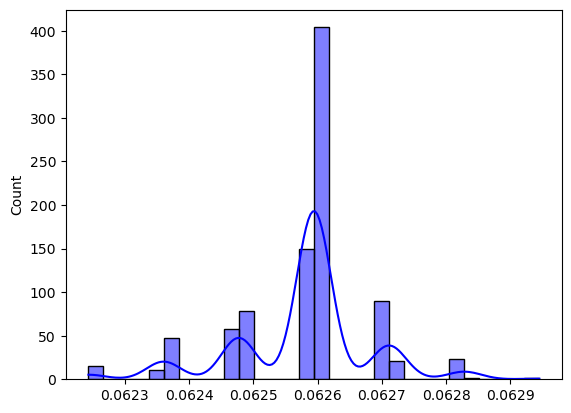

In [338]:
sns.histplot(roznice, bins=30, kde=True, color='blue', edgecolor='black')
fig.update_layout(title=None)
plt.savefig("newplot4.png", dpi=300, bbox_inches='tight', facecolor='white')

## Random forest

In [6]:
X_train, X_test, y_train, y_test = train_test_split(zbior.iloc[:, :-1], zbior['Target'], test_size=0.30, random_state=42)

def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 100, 2000, step=100)
    max_depth = trial.suggest_int("max_depth", 1, 30, log=True)
    min_samples_split = trial.suggest_int("min_samples_split", 1, 60)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10) 

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    wyniki = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_fold = X_train_fold.reset_index(drop=True)
        X_test_fold = X_test_fold.reset_index(drop=True)
        y_train_fold = y_train_fold.reset_index(drop=True)
        y_test_fold = y_test_fold.reset_index(drop=True)

        X_train_fold = list(zip(*[X_train_fold[col] for col in X_train_fold]))
        X_test_fold = list(zip(*[X_test_fold[col] for col in X_test_fold]))

        Las_losowy = RandomForestClassifier(n_estimators = n_estimators, max_depth=max_depth, min_samples_split=min_samples_split,
                                            min_samples_leaf = min_samples_leaf)

        Las_losowy.fit(X_train_fold, y_train_fold)

        Las_losowy.predict(X_test_fold)
                                            
        wynik = Las_losowy.score(X_test_fold, y_test_fold)
        wyniki.append(wynik)

    rezultat = np.mean(wyniki)
    return rezultat

In [7]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
wynik = study.optimize(objective, n_trials=10)

In [ ]:
study.best_params

In [ ]:
##Las_losowy defaultowo
Las_losowy = RandomForestClassifier(n_estimators = 1000, max_depth=30, min_samples_split=20,
                                            min_samples_leaf = 7).fit(X_train,y_train)
Las_losowy.predict(X_test)
wynik = Las_losowy.score(X_test, y_test)
print(wynik)

In [ ]:
Las_losowy = RandomForestClassifier(n_estimators = 1000, max_depth=18, min_samples_split=7,
                                            min_samples_leaf = 1).fit(X_train,y_train)
Las_losowy.predict(X_test)
wynik = Las_losowy.score(X_test, y_test)
print(wynik)

In [ ]:
wszystkie_triale = study.trials
wyniki = [t.value for t in wszystkie_triale if t.state == optuna.trial.TrialState.COMPLETE]
roznice = []
for i in wyniki:
    roznice.append(i-wynik)
    

In [ ]:
roznice

## XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(zbior.iloc[:, :-1], zbior['Target'], test_size=0.30, random_state=42)

def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    wyniki = []

    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        X_train_fold = X_train_fold.reset_index(drop=True)
        X_test_fold = X_test_fold.reset_index(drop=True)
        y_train_fold = y_train_fold.reset_index(drop=True)
        y_test_fold = y_test_fold.reset_index(drop=True)

        X_train_fold = list(zip(*[X_train_fold[col] for col in X_train_fold]))
        X_test_fold = list(zip(*[X_test_fold[col] for col in X_test_fold]))

        XGBoost = XGBClassifier(max_depth = max_depth, learning_rate = learning_rate, n_estimators = n_estimators,
                               subsample = subsample, colsample_bytree = colsample_bytree, min_child_weight = min_child_weight)

        XGBoost.fit(X_train_fold, y_train_fold)

        XGBoost.predict(X_test_fold)
                                            
        wynik = XGBoost.score(X_test_fold, y_test_fold)
        wyniki.append(wynik)

    rezultat = np.mean(wyniki)
    return rezultat

In [ ]:
study = optuna.create_study(direction='maximize',sampler=TPESampler())
wynik = study.optimize(objective, n_trials=100)

In [ ]:
study.best_params

In [ ]:
XGBoost = XGBClassifier(max_depth = 7, learning_rate = 0.014059646736310738, n_estimators = 811,
                               subsample = 0.8746931123404836, colsample_bytree = 0.7067553318391634, min_child_weight = 1).fit(X_train,y_train)
XGBoost.predict(X_test)
wynik = XGBoost.score(X_test, y_test)
print(wynik)